In [70]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objs as go
#import plotly.offline as py

import operator
import scipy

from scipy.stats import norm
#import scipy.stats as st
import scipy.stats as stats

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#from sklearn.preprocessing import min_max_scaler
#from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split

#from mlxtend.regressor import StackingCVRegressor

from sklearn.preprocessing import RobustScaler,robust_scale,MinMaxScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV,Ridge,Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV

In [6]:
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

full = train.append(test, ignore_index = True,sort=False)

In [7]:
#full.drop(['LotFrontage'],axis=1,inplace = True) 

full.MasVnrArea = full.MasVnrArea.fillna(0.) 

full.GarageCars = full.GarageCars.fillna(0.) 
full.GarageArea = full.GarageArea.fillna(0.) 
full.GarageYrBlt = full.GarageYrBlt.fillna(0.)

full.BsmtFinSF1 = full.BsmtFinSF1.fillna(0.)
full.BsmtFinSF2 = full.BsmtFinSF2.fillna(0.)
full.BsmtUnfSF = full.BsmtUnfSF.fillna(0.)
full.BsmtFullBath = full.BsmtFullBath.fillna(0.)
full.BsmtHalfBath = full.BsmtHalfBath.fillna(0.)
full.TotalBsmtSF = full.TotalBsmtSF.fillna(0.)


In [8]:
full.drop(['PoolQC'],axis=1,inplace = True) 
full.drop(['MiscFeature'],axis=1,inplace = True) 
full.drop(['Alley'],axis=1,inplace = True)   
full.drop(['Fence'],axis=1,inplace = True) 
#full['PoolQC'] = full['PoolQC'].fillna(full['PoolQC'].mode()[0])  

full['Electrical'] = full['Electrical'].fillna(full['Electrical'].mode()[0])  

full['SaleType'] = full['SaleType'].fillna(full['SaleType'].mode()[0]) 

full['MSZoning'] = full['MSZoning'].fillna(full['MSZoning'].mode()[0])  

full['KitchenQual'] = full['KitchenQual'].fillna(full['KitchenQual'].mode()[0]) 



full['MasVnrType'] = full['MasVnrType'].fillna('Missing')    

full['Exterior1st'] = full['Exterior1st'].fillna(full['Exterior1st'].mode()[0])
full['Exterior2nd'] = full['Exterior2nd'].fillna(full['Exterior2nd'].mode()[0])    

#full['Fence'] = full['Fence'].fillna('Missing')
full['FireplaceQu'] = full['FireplaceQu'].fillna('Missing')

full['Functional'] = full['Functional'].fillna('Typ')

full['GarageType'] = full['GarageType'].fillna('Missing')
full['GarageFinish'] = full['GarageFinish'].fillna('Missing')
full['GarageQual'] = full['GarageQual'].fillna('Missing')
full['GarageCond'] = full['GarageCond'].fillna('Missing')


    
full['BsmtExposure'] = full['BsmtExposure'].fillna('Missing')
full['BsmtFinType1'] = full['BsmtFinType1'].fillna('Missing')
full['BsmtFinType2'] = full['BsmtFinType2'].fillna('Missing')
full['BsmtQual'] = full['BsmtQual'].fillna('Missing')
full['BsmtCond'] = full['BsmtCond'].fillna('Missing')

full.drop(['Utilities'],axis=1,inplace = True) 
full.drop(['Street'],axis=1,inplace = True)

full['LotFrontage'] = full.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [9]:
train = full[full.SalePrice.notnull()]
test = full[full.SalePrice.isnull()]

In [10]:
train = train[train['GrLivArea'] < 4500]
train.reset_index(drop=True, inplace=True)


In [11]:

outliers = [30, 88, 462, 631, 1322]

train = train.drop(train.index[outliers])

In [12]:
#train = train[train['LotArea'] < 100000]
#train = train[train['TotalBsmtSF'] < 3000]
#train = train[train['1stFlrSF'] < 2500]
#train = train[train['BsmtFinSF1'] < 2000]

In [13]:
full =  train.append(test, ignore_index = True,sort=False)

## Feature Engineering

In [14]:
full['YearBuiltemodel']=(full['YearBuilt']+full['YearRemodAdd'])
full['TotalSF']=(full['TotalBsmtSF'] + full['1stFlrSF'] + full['2ndFlrSF'])
full['basement']=full['BsmtFinSF2']+full['BsmtUnfSF']
full['Total_sqr_footage'] = (full['BsmtFinSF1'] + full['BsmtFinSF2'] + full['1stFlrSF'] + full['2ndFlrSF'])

#full['Total_Bathrooms'] = (full['fullBath'] + (0.5 * full['HalfBath']) + full['BsmtfullBath'] + (0.5 * full['BsmtHalfBath']))
full['Total_Bathrooms'] = (full['FullBath'] + (0.5 * full['HalfBath']) + full['BsmtFullBath'] + (0.5 * full['BsmtHalfBath']))

full['Total_porch_sf'] = (full['OpenPorchSF'] + full['3SsnPorch'] + full['EnclosedPorch'] + full['ScreenPorch'] +
                              full['WoodDeckSF'])
full['haspool'] = full['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
full['has2ndfloor'] = full['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
full['hasgarage'] = full['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
full['hasbsmt'] = full['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
full['hasfireplace'] = full['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
full["SalePrice"] = np.log1p(full["SalePrice"])
full["LotArea"] = np.log1p(full["LotArea"])
full["BsmtUnfSF"] = np.log1p(full["BsmtUnfSF"])
full["MasVnrArea"] = np.log1p(full["MasVnrArea"])
full["TotalBsmtSF"] = np.log1p(full["TotalBsmtSF"])
full["1stFlrSF"] = np.log1p(full["1stFlrSF"])
full["GrLivArea"] = np.log1p(full["GrLivArea"])

In [15]:
full = pd.get_dummies(full).reset_index(drop=True)

In [16]:
train_df = full[full.SalePrice.notnull()]
test_df = full[full.SalePrice.isnull()]

In [17]:
y = train_df['SalePrice']

In [18]:
test_df.drop(['SalePrice'], axis=1, inplace=True)
train_df.drop(['SalePrice'], axis=1, inplace=True)

C:\Users\Parth\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [19]:
X = train_df
X_sub = test_df


In [20]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)
overfit

[]

In [21]:
X.shape, y.shape, X_sub.shape

((1453, 292), (1453L,), (1459, 292))


#### Create Train and Test Sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2 ,random_state=42)

In [23]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse_train(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X,y_train, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

def cv_rmse_test(model, X=X_test):
    rmse = np.sqrt(-cross_val_score(model, X, y_test, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

## Modelling

Steps Involved in regression modelling
* Preprocess Data
* Create Train and Test Sets
* Instantiate the model/estimator
* (Steps 1 and 3 can be combined in a Pipeline object)
* Specify Hyperparameter Space
* Instantiate RandomizedSearchCV objects
* Fit CV object to the Training Set
* Predict on the Test Set
* Compute Scores for the Model

### Models used:


* Lasso
* Ridge
* ElasticNet
* Random Forest
* Gradient Boost
* LightGM
* XgBoost
* ADA Boost

## Lasso

#### Hyperparameter Tuning


In [24]:
#alphas_alt = {'alpha': [0.1,1,10,50,100],
#             'max_iter' : [100,3000,5000]}
alphas_alt = {'alpha': [0.001,0.005,0.01],
             'max_iter' :[100000,300000,500000]}

losso = Lasso(normalize=RobustScaler())

In [322]:
losso = RandomizedSearchCV(estimator = losso, param_distributions =alphas_alt, n_iter=5, cv = 5, verbose=2,n_jobs=-1, random_state=42)
losso.fit(X_train, y_train)

print('score parameters for losso Regression Model : {}'.format(losso.grid_scores_))
print('Best parameters for losso Regression Model : {}'.format(losso.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:   24.1s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   24.1s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True),
   positive=False, precompute=False, random_state=None, selection='cyclic',
   tol=0.0001, warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'alpha': [0.001, 0.005, 0.01], 'max_iter': [10000, 30000]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

####  Creating final Lasso Model and checking test and train score

In [25]:
losso_final = Lasso(alpha = 0.001, max_iter= 10000,normalize=RobustScaler())
losso_final.fit(X_train, y_train)
#prediction = losso_final.predict(X_test)
print("Training accuracy:",losso_final.score(X_train,y_train))
print("Testing accuracy:",losso_final.score(X_test,y_test))

('Training accuracy:', 0.8802840975630363)
('Testing accuracy:', 0.8728072923293472)


In [326]:
score = cv_rmse_train(losso_final)
print("train data score of losso Regression: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('train data score of losso Regression: 0.1367 (0.0145) 0.1513\n', datetime.datetime(2019, 4, 23, 19, 57, 19, 31000))


In [325]:
score = cv_rmse_test(losso_final)
print("test data score of losso Regression: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('test data score of losso Regression: 0.1282 (0.0276) 0.1558\n', datetime.datetime(2019, 4, 23, 19, 57, 15, 588000))


#### Finding important features

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

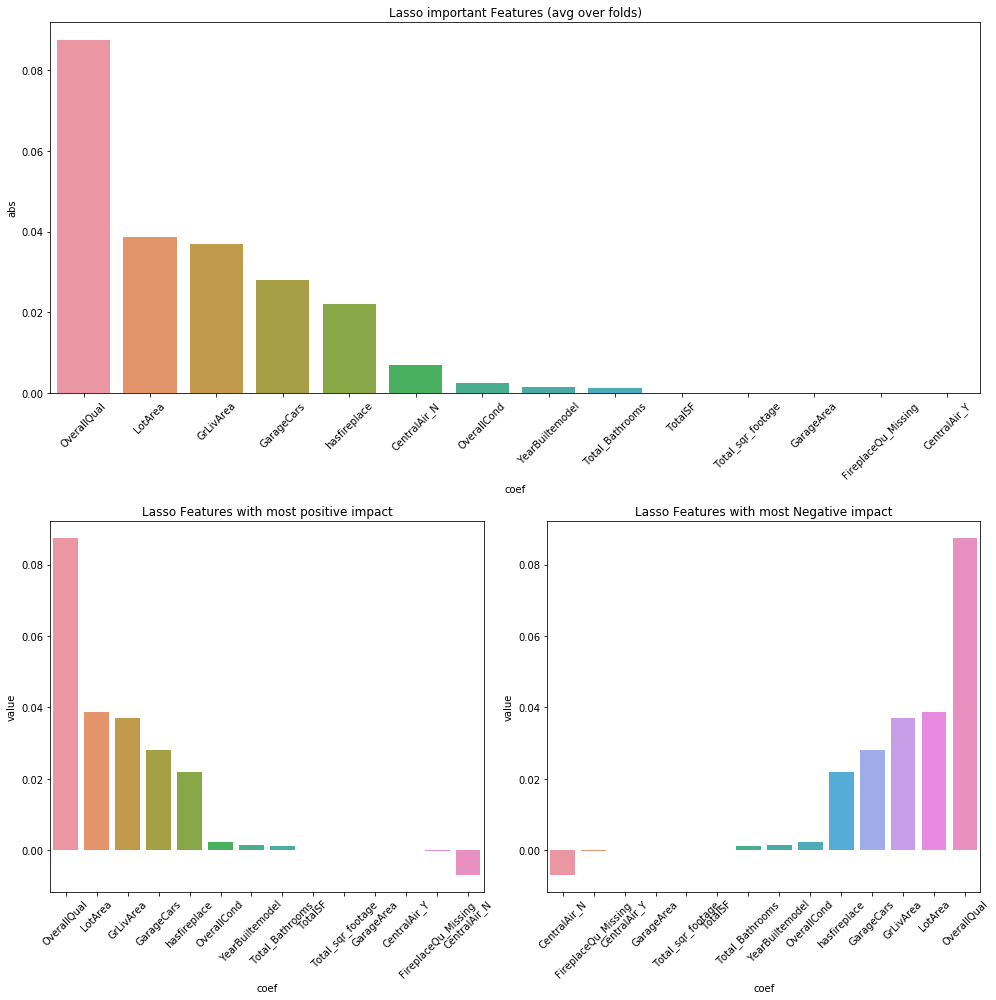

In [26]:

label_lasso=pd.DataFrame(list(zip(X.columns,losso_final.coef_)),columns=['coef','value']).sort_values(by='value')
label_lasso = label_lasso[label_lasso.value!=0]
label_lasso['abs']=label_lasso.value.apply(lambda x:abs(x))
label_lasso['sign']=label_lasso.value.apply(lambda x: x/abs(x))

plt.figure(figsize = (14,14))
ax = plt.subplot2grid((2,2), (0,0), rowspan = 1, colspan = 2)

###########################################################################################################################
label_lasso_abs= label_lasso.sort_values(by='abs', ascending=False)
label_lasso_abs=label_lasso_abs.head(30)

sns.barplot(x="coef",
            y="abs",
             ax = ax, 
            data=label_lasso_abs.sort_values(by="abs", ascending=False))
plt.title('Lasso important Features (avg over folds)')
plt.tight_layout()
plt.xticks(rotation=45)

###########################################################################################################################
ax1 = plt.subplot2grid((2,2), (1,0), rowspan = 1, colspan = 1)

label_lasso_pos= label_lasso.sort_values(by='value', ascending=False)
label_lasso_pos=label_lasso_pos.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax1, 
            data=label_lasso_pos.sort_values(by="value", ascending=False))
plt.title('Lasso Features with most positive impact')
plt.tight_layout()
plt.xticks(rotation=45)

###########################################################################################################################
ax2 = plt.subplot2grid((2,2), (1,1), rowspan = 1, colspan = 1)

label_lasso_neg= label_lasso.sort_values(by='value', ascending=True)
label_lasso_neg=label_lasso_neg.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax2, 
            data=label_lasso_neg.sort_values(by="value", ascending=True))
plt.title('Lasso Features with most Negative impact')
plt.tight_layout()
plt.xticks(rotation=45)


### LassoCV

#### Hyperparameter Tuning

In [28]:
#alphas = [0.001,0.005 ,0.01,0.05,0.1,0.5,1]
alphas = [5e-05,0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]
#ittr = [1000,1000,5000,10000,50000,100000]
ittr = [100000]
#tol=[0.001,0.005,0.01,0.05,0.1]
tol=[0.001]



#### Final Model with final CV parameter

In [29]:
lassocv = make_pipeline(RobustScaler(), LassoCV(alphas=alphas,max_iter=100000, tol=0.001,cv=kfolds))

lassocv.fit(X_train, y_train)
print("Training accuracy:",lassocv.score(X_train,y_train))
print("Testing accuracy:",lassocv.score(X_test,y_test))

('Training accuracy:', 0.9456819314290723)
('Testing accuracy:', 0.9182004979205508)


In [330]:
score = cv_rmse_train(lassocv)
print("Test data score of lossoCV: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('Test data score of lossoCV: 0.1013 (0.0124) 0.1137\n', datetime.datetime(2019, 4, 23, 20, 0, 20, 87000))


In [331]:
score = cv_rmse_test(lassocv)
print("test data score of losso Regression: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('test data score of losso Regression: 0.1329 (0.0156) 0.1484\n', datetime.datetime(2019, 4, 23, 20, 0, 53, 293000))


## Ridge

#### Hyperparameter Tuning

In [30]:
#alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
#alphas_alt = [0.1,1,5,10,15,20]
#alphas_alt = {'alpha': [10,14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5,100]}
alphas_alt = {'alpha': [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1],
             'max_iter' :[100000,300000,500000]
             }


ridge = Ridge(normalize=RobustScaler())


In [343]:
ridge = RandomizedSearchCV(estimator = ridge, param_distributions =alphas_alt, n_iter=5, cv = 5, verbose=2,n_jobs=-1, random_state=42)
ridge.fit(X_train, y_train)

print('score parameters for Ridge Regression Model : {}'.format(ridge.grid_scores_))
print('Best parameters for Ridge Regression Model : {}'.format(ridge.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:   22.4s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   22.4s finished


score parameters for Ridge Regression Model : [mean: 0.92522, std: 0.00905, params: {'alpha': 0.5, 'max_iter': 500000}, mean: 0.92231, std: 0.00871, params: {'alpha': 0.7, 'max_iter': 300000}, mean: 0.92380, std: 0.00886, params: {'alpha': 0.6, 'max_iter': 100000}, mean: 0.91760, std: 0.00841, params: {'alpha': 1, 'max_iter': 100000}, mean: 0.92759, std: 0.00959, params: {'alpha': 0.3, 'max_iter': 100000}]
Best parameters for Ridge Regression Model : {'alpha': 0.3, 'max_iter': 100000}


#### Creating Final Model

In [31]:
ridge_final = Ridge(alpha = 0.3, max_iter= 100000,normalize=RobustScaler())
ridge_final.fit(X_train, y_train)
#prediction = ridge_final.predict(X_test)
print("Training accuracy:",ridge_final.score(X_train,y_train))
print("Testing accuracy:",ridge_final.score(X_test,y_test))

('Training accuracy:', 0.9534358969213684)
('Testing accuracy:', 0.9152933062270626)


In [345]:
score = cv_rmse_train(ridge_final)
print("train data score of Ridge Regression: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('train data score of Ridge Regression: 0.1042 (0.0099) 0.1141\n', datetime.datetime(2019, 4, 23, 20, 7, 7, 385000))


In [346]:
score = cv_rmse_test(ridge_final)
print("test data score of Ridge Regression: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('test data score of Ridge Regression: 0.1421 (0.0392) 0.1813\n', datetime.datetime(2019, 4, 23, 20, 7, 9, 958000))



#### Important Features

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

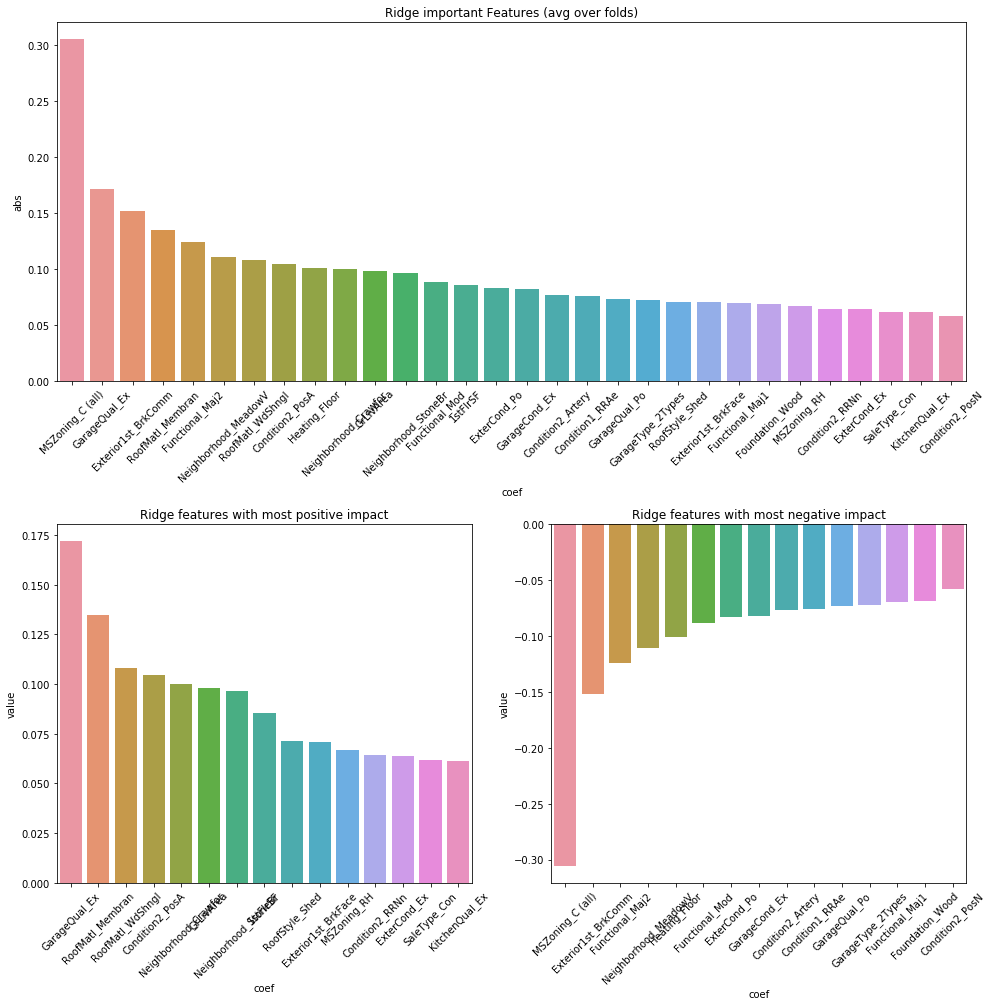

In [32]:
label_ridge=pd.DataFrame(list(zip(X.columns,ridge_final.coef_)),columns=['coef','value']).sort_values(by='value')
label_ridge = label_ridge[label_ridge.value!=0]
label_ridge['abs']=label_ridge.value.apply(lambda x:abs(x))
label_ridge['sign']=label_ridge.value.apply(lambda x: x/abs(x))

plt.figure(figsize = (14,14))
ax = plt.subplot2grid((2,2), (0,0), rowspan = 1, colspan = 2)

###########################################################################################################################
label_ridge_abs= label_ridge.sort_values(by='abs', ascending=False)
label_ridge_abs=label_ridge_abs.head(30)

sns.barplot(x="coef",
            y="abs",
             ax = ax, 
            data=label_ridge_abs.sort_values(by="abs", ascending=False))
plt.title('Ridge important Features (avg over folds)')
plt.tight_layout()
plt.xticks(rotation=45)

###########################################################################################################################
ax1 = plt.subplot2grid((2,2), (1,0), rowspan = 1, colspan = 1)

label_ridge_pos= label_ridge.sort_values(by='value', ascending=False)
label_ridge_pos=label_ridge_pos.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax1, 
            data=label_ridge_pos.sort_values(by="value", ascending=False))
plt.title('Ridge features with most positive impact')
plt.tight_layout()
plt.xticks(rotation=45)

###########################################################################################################################
ax2 = plt.subplot2grid((2,2), (1,1), rowspan = 1, colspan = 1)

label_ridge_neg= label_ridge.sort_values(by='value', ascending=True)
label_ridge_neg=label_ridge_neg.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax2, 
            data=label_ridge_neg.sort_values(by="value", ascending=True))
plt.title('Ridge features with most negative impact')
plt.tight_layout()
plt.xticks(rotation=45)


### RidgeCV

#### Hyperparameter Tuning

In [367]:
#alphas = (1,14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5,20) #0.0.1387 
alphas = (1,3,5,7,9,11,13,14.5, 14.6, 14.7, 14.8, 14.9, 15) #0.0.0.1399  

#alphas = (0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1) # 0.0.1690 
#alphas = (14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5) # 0.1267 
#alphas = (10,11,12,13,14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1) ## 0.1267
#alphas = (14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1) ## 0.1267
#alphas = (0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5) #0.1288 
#alphas = (0.3,0.5,1,2,3) #0.0.1553   



#### Final Model with Test and Train Accuracy



In [103]:
ridgecv = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas,cv=kfolds))
ridgecv.fit(X_train, y_train)

print("Training accuracy:",ridgecv.score(X_train,y_train))
print("Testing accuracy:",ridgecv.score(X_test,y_test))

('Training accuracy:', 0.9614196194083897)
('Testing accuracy:', 0.9119914913531318)


In [370]:
score = cv_rmse_train(ridgecv)
print("Test data score of ridgecv: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('Test data score of ridgecv: 0.0997 (0.0112) 0.1109\n', datetime.datetime(2019, 4, 23, 20, 13, 38, 601000))


In [369]:
score = cv_rmse_test(ridgecv)
print("test data score of ridgecv Regression: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('test data score of ridgecv Regression: 0.1399 (0.0500) 0.1898\n', datetime.datetime(2019, 4, 23, 20, 12, 46, 341000))


# ElasticNet
#### Hyperparameter Tuning


In [33]:
#alphas_alt = {'alpha': [0.0001, 0.001,0.01,0.1,1,10,100,2000],
#             'max_iter' : [300,500,1000,3000]}
#alphas_alt = {'alpha': [0.0001,0.0003,0.0005,0.0007,0.0009, 0.001,0.003,0.005,0.007,0.009,0.01],
#             'max_iter' : [300,500,1000,3000]}
#alphas_alt = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,0.0008,0.0009, 0.001],
#             'max_iter' : [50000,1000000],
#             'l1_ratio':[0.1,1,10]}
#alphas_alt = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,0.0008,0.0009, 0.001],
#             'max_iter' : [30000,50000,1000000]
 #            'l1_ratio':[0.8, 0.85, 0.9, 0.95, 0.99, 1,1.05,1.1,1.15,1.2,1.25]
#             }
alphas_alt = {'alpha': [ 0.0007,0.0008,0.0009, 0.001],
             'max_iter' : [30000,50000,1000000]
 #            'l1_ratio':[0.8, 0.85, 0.9, 0.95, 0.99, 1,1.05,1.1,1.15,1.2,1.25]
             }
elasticnet = ElasticNet(normalize=RobustScaler())

In [388]:
elasticnet = RandomizedSearchCV(estimator = elasticnet, param_distributions =alphas_alt, n_iter=5, cv = 5, verbose=2,n_jobs=-1, random_state=42)
elasticnet.fit(X_train, y_train)

print('score parameters for elasticnet Regression Model : {}'.format(elasticnet.grid_scores_))
print('Best parameters for elasticnet Regression Model : {}'.format(elasticnet.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
score parameters for elasticnet Regression Model : [mean: 0.90660, std: 0.00909, params: {'alpha': 0.001, 'max_iter': 50000}, mean: 0.90660, std: 0.00909, params: {'alpha': 0.001, 'max_iter': 30000}, mean: 0.91930, std: 0.00877, params: {'alpha': 0.0007, 'max_iter': 30000}, mean: 0.91093, std: 0.00895, params: {'alpha': 0.0009, 'max_iter': 1000000}, mean: 0.91512, std: 0.00882, params: {'alpha': 0.0008, 'max_iter': 1000000}]
Best parameters for elasticnet Regression Model : {'alpha': 0.0007, 'max_iter': 30000}


[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:   21.5s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   21.6s finished


#### Creating Final ElasticNet Model

In [34]:
#elasticnet_final = ElasticNet(alpha = 0.001, max_iter= 50000,normalize=RobustScaler())
elasticnet_final = ElasticNet(alpha = 0.0007, max_iter= 30000,normalize=RobustScaler())

elasticnet_final.fit(X_train, y_train)
#prediction = elasticnet_final.predict(X_test)
print("Training accuracy:",elasticnet_final.score(X_train,y_train))
print("Testing accuracy:",elasticnet_final.score(X_test,y_test))

('Training accuracy:', 0.9240253659884659)
('Testing accuracy:', 0.9074442796813187)


In [391]:
score = cv_rmse_train(elasticnet_final)
print("train data score of elasticnet Regression: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('train data score of elasticnet Regression: 0.1138 (0.0120) 0.1258\n', datetime.datetime(2019, 4, 23, 20, 19, 21, 657000))


In [390]:
score = cv_rmse_test(elasticnet_final)
print("test data score of elasticnet Regression: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('test data score of elasticnet Regression: 0.1252 (0.0141) 0.1393\n', datetime.datetime(2019, 4, 23, 20, 19, 17, 328000))


#### Important Features

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

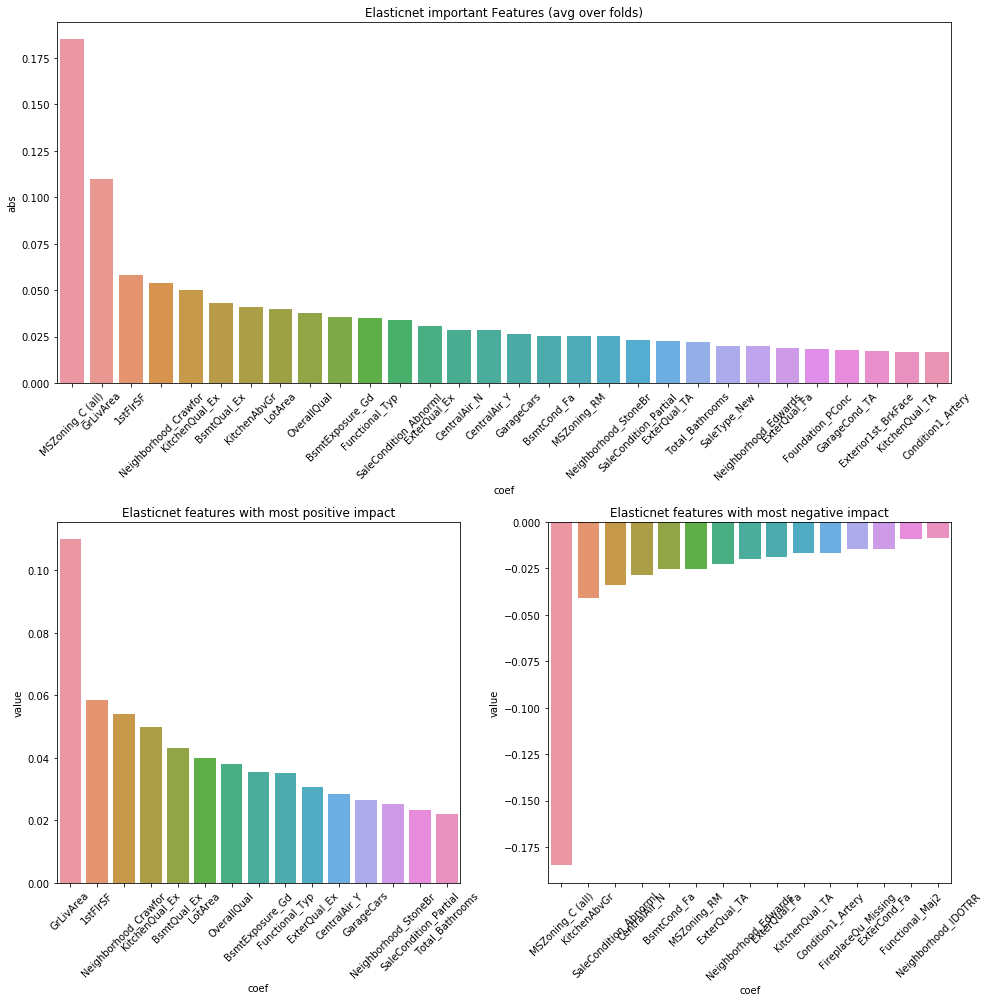

In [35]:
label_elasticnet=pd.DataFrame(list(zip(X.columns,elasticnet_final.coef_)),columns=['coef','value']).sort_values(by='value')
label_elasticnet = label_elasticnet[label_elasticnet.value!=0]
label_elasticnet['abs']=label_elasticnet.value.apply(lambda x:abs(x))
label_elasticnet['sign']=label_elasticnet.value.apply(lambda x: x/abs(x))

plt.figure(figsize = (14,14))
ax = plt.subplot2grid((2,2), (0,0), rowspan = 1, colspan = 2)

###########################################################################################################################
label_elasticnet_abs= label_elasticnet.sort_values(by='abs', ascending=False)
label_elasticnet_abs=label_elasticnet_abs.head(30)

sns.barplot(x="coef",
            y="abs",
             ax = ax, 
            data=label_elasticnet_abs.sort_values(by="abs", ascending=False))
plt.title('Elasticnet important Features (avg over folds)')
plt.tight_layout()
plt.xticks(rotation=45)

###########################################################################################################################
ax1 = plt.subplot2grid((2,2), (1,0), rowspan = 1, colspan = 1)

label_elasticnet_pos= label_elasticnet.sort_values(by='value', ascending=False)
label_elasticnet_pos=label_elasticnet_pos.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax1, 
            data=label_elasticnet_pos.sort_values(by="value", ascending=False))
plt.title('Elasticnet features with most positive impact')
plt.tight_layout()
plt.xticks(rotation=45)

###########################################################################################################################
ax2 = plt.subplot2grid((2,2), (1,1), rowspan = 1, colspan = 1)

label_elasticnet_neg= label_elasticnet.sort_values(by='value', ascending=True)
label_elasticnet_neg=label_elasticnet_neg.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax2, 
            data=label_elasticnet_neg.sort_values(by="value", ascending=True))
plt.title('Elasticnet features with most negative impact')
plt.tight_layout()
plt.xticks(rotation=45)


# ElasticNetCV

In [98]:
#alphas2 = [ 0.0004, 0.0005, 0.0006, 0.0007,0.0008,0.0009,0.001]
#alphas2 = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
#alphas2 = [ 3.6,3.7,3.8,3.9,3.95,4,4.05,4.1,4.2,4.3,4.4]

#e_l1ratio = [0.003,0.004,0.005,0.006,0.007,0.008]


alphas2 = [ 0.0004, 0.0005, 0.0006, 0.0007,0.0008,0.0009,0.001]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1,1.05,1.1,1.15,1.2,1.25]

In [104]:

elasticnetcv = make_pipeline(RobustScaler(),ElasticNetCV( max_iter=1e7, alphas=alphas2, tol=0.0001,cv=kfolds, l1_ratio=e_l1ratio))                                

elasticnetcv.fit(X_train, y_train)
print("Training accuracy:",elasticnetcv.score(X_train,y_train))
print("Testing accuracy:",elasticnetcv.score(X_test,y_test))

('Training accuracy:', 0.9544412071265254)
('Testing accuracy:', 0.9148090836620624)


In [84]:
score = cv_rmse_train(elasticnetcv)
print("Train data score of elasticnetcv: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )


('Train data score of elasticnetcv: 0.0986 (0.0097) 0.1084\n', datetime.datetime(2019, 4, 27, 14, 0, 20, 354000))


In [100]:

score = cv_rmse_test(elasticnetcv)
print("test data score of elasticnetcv Regression: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('test data score of elasticnetcv Regression: 0.1430 (0.0457) 0.1887\n', datetime.datetime(2019, 4, 27, 14, 16, 15, 503000))


# Random Forest

In [37]:
#gb_est = {'n_estimators': [500,1000,3000,5000],
   #          'max_depth':[2,5,10],
  #           'max_features': ['auto','sqrt','log2',None],
#              'min_samples_leaf':[2,5,10,15,20],
 #             'min_samples_split':[5,10,15,50,100],
#          'min_weight_fraction_leaf':[]
            #  'loss':['huber','quantile'],
            #  'random_state':[42]
#             } Best parameters for Random Forest Regression Model : {'n_estimators': 3000, 'min_samples_split': 10, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5}

#gb_est = {'n_estimators': [2500,3000,3500,],
#             'max_depth':[5,6,7],
#             'max_features': ['log2',None],
#              'min_samples_leaf':[3,5,7],
#              'min_samples_split':[8,10,12],
#          'min_weight_fraction_leaf':[]
            #  'loss':['huber','quantile'],
            #  'random_state':[42]
 #            }
gb_est = {'n_estimators': [2500,3000,3500,10000,50000,100000],
             'max_depth':[5,6],
             'max_features': ['log2',None],
              'min_samples_leaf':[3,5,7],
              'min_samples_split':[8,10,12],
#          'min_weight_fraction_leaf':[]
            #  'loss':['huber','quantile'],
            #  'random_state':[42]
             }
randomforest = RandomForestRegressor()

In [397]:
randomforest = RandomizedSearchCV(estimator = randomforest, param_distributions =gb_est, n_iter=8, cv = 5, verbose=2,n_jobs=-1, random_state=42)
randomforest.fit(X_train,y_train)

print('score parameters for Random Forest Regression Model : {}'.format(randomforest.grid_scores_))
print('Best parameters for Random Forest Regression Model : {}'.format(randomforest.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  9.0min remaining:   28.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  9.2min finished


score parameters for Random Forest Regression Model : [mean: 0.87553, std: 0.01193, params: {'n_estimators': 10000, 'min_samples_split': 8, 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 7}, mean: 0.87553, std: 0.01207, params: {'n_estimators': 10000, 'min_samples_split': 12, 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 7}, mean: 0.80621, std: 0.01094, params: {'n_estimators': 2500, 'min_samples_split': 12, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 5}, mean: 0.87915, std: 0.01221, params: {'n_estimators': 10000, 'min_samples_split': 12, 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 3}, mean: 0.78526, std: 0.01046, params: {'n_estimators': 10000, 'min_samples_split': 12, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 3}, mean: 0.81282, std: 0.01034, params: {'n_estimators': 10000, 'min_samples_split': 8, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 3}, mean: 0.87793, std: 0.01173, params: {'n_estimators': 

In [38]:
#randomforest_final = RandomForestRegressor(n_estimators = 3500, max_depth= 7,max_features=None,min_samples_leaf=7,min_samples_split=10,n_jobs=-1)
randomforest_final = RandomForestRegressor(n_estimators = 10000, max_depth= 6,max_features=None,min_samples_leaf=3,min_samples_split=12,n_jobs=-1)

randomforest_final.fit(X_train,y_train)
#prediction = randomforest_final.predict(X_test)
print("Training accuracy:",randomforest_final.score(X_train,y_train))
print("Testing accuracy:",randomforest_final.score(X_test,y_test))


('Training accuracy:', 0.9362255949792385)
('Testing accuracy:', 0.8623157210705478)


In [212]:
score = cv_rmse_train(randomforest_final)
print("Train data score of Random Forest Regression: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )


('Test data score of lossoCV: 0.1363 (0.0152) 0.1515\n', datetime.datetime(2019, 4, 23, 9, 8, 40, 928000))


In [400]:
score = cv_rmse_test(randomforest_final)
print("test data score of Random Forest Regression: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('test data score of Random Forest Regression: 0.1582 (0.0304) 0.1885\n', datetime.datetime(2019, 4, 23, 20, 55, 20, 697000))


#### important Features

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

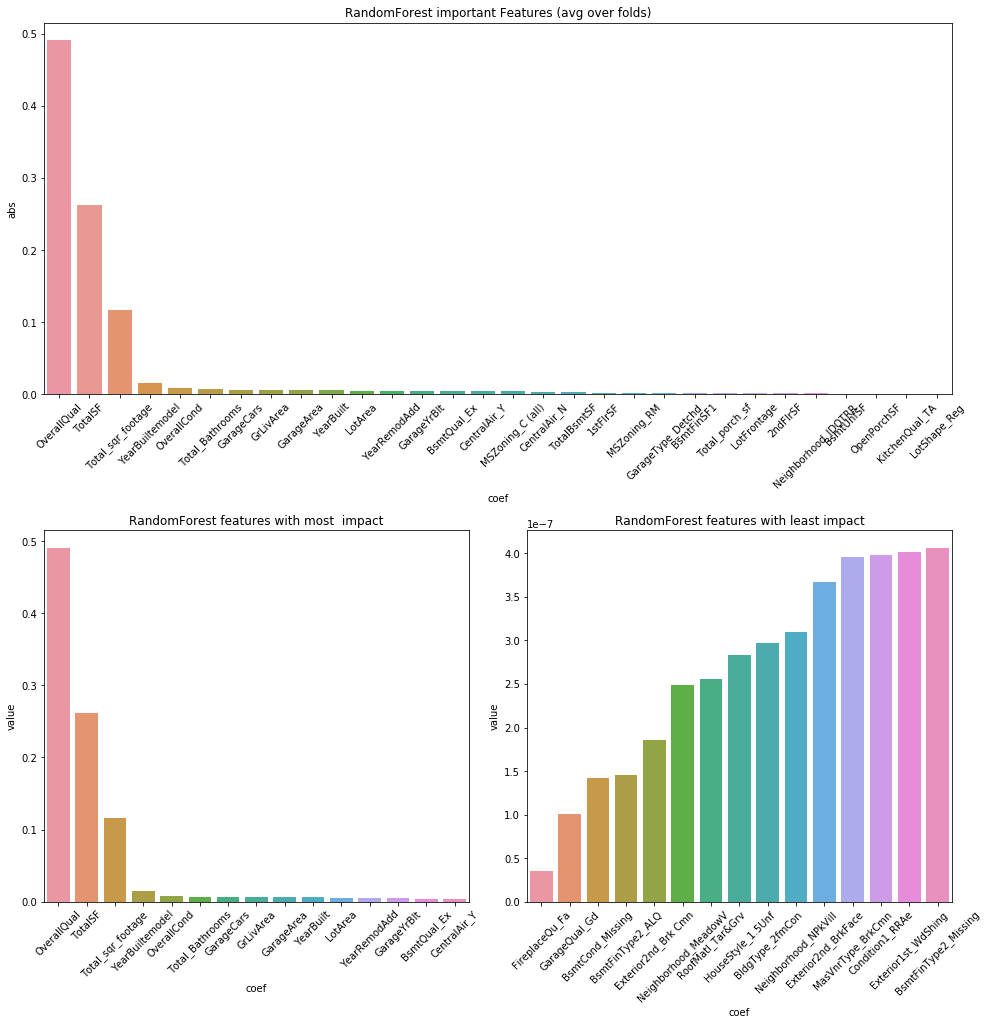

In [39]:
label_randomforest=pd.DataFrame(list(zip(X.columns,randomforest_final.feature_importances_)),columns=['coef','value']).sort_values(by='value')


#label_elasticnet=pd.DataFrame(list(zip(X.columns,elasticnet_final.coef_)),columns=['coef','value']).sort_values(by='value')
label_randomforest = label_randomforest[label_randomforest.value!=0]
label_randomforest['abs']=label_randomforest.value.apply(lambda x:abs(x))
label_randomforest['sign']=label_randomforest.value.apply(lambda x: x/abs(x))

plt.figure(figsize = (14,14))
ax = plt.subplot2grid((2,2), (0,0), rowspan = 1, colspan = 2)

###########################################################################################################################
label_randomforest_abs= label_randomforest.sort_values(by='abs', ascending=False)
label_randomforest_abs=label_randomforest_abs.head(30)

sns.barplot(x="coef",
            y="abs",
             ax = ax, 
            data=label_randomforest_abs.sort_values(by="abs", ascending=False))
plt.title('RandomForest important Features (avg over folds)')
plt.tight_layout()
plt.xticks(rotation=45)
###########################################################################################################################

ax1 = plt.subplot2grid((2,2), (1,0), rowspan = 1, colspan = 1)

label_randomforest_pos= label_randomforest.sort_values(by='value', ascending=False)
label_randomforest_pos=label_randomforest_pos.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax1, 
            data=label_randomforest_pos.sort_values(by="value", ascending=False))
plt.title('RandomForest features with most  impact')
plt.tight_layout()
plt.xticks(rotation=45)

###########################################################################################################################
ax2 = plt.subplot2grid((2,2), (1,1), rowspan = 1, colspan = 1)

label_randomforest_neg= label_randomforest.sort_values(by='value', ascending=True)
label_randomforest_neg=label_randomforest_neg.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax2, 
            data=label_randomforest_neg.sort_values(by="value", ascending=True))
plt.title('RandomForest features with least impact')
plt.tight_layout()
plt.xticks(rotation=45)


# Gradient Boost

In [402]:
#n_estimators=3000, 
#learning_rate=0.05,
#max_depth=4,
#max_features='sqrt', 
#min_samples_leaf=15,
#min_samples_split=10, 
#loss='huber',
#random_state =42

#gb_est = {'n_estimators': [500,1000,3000,5000],
#             'learning_rate' : [0.0001,0.001,0.01,0.1,1,10],
#             'max_depth':[2,5,10],
#             'max_features': ['auto','sqrt','log2',None],
#              'min_samples_leaf':[2,5,10,15,20],
#              'min_samples_split':[5,1,15,50,100],
#              'loss':['huber','quantile'],
#              'random_state':[42]
#             }
gb_est = {'n_estimators': [2000,3000,4000],
             'learning_rate' : [0.01,0.02,0.03,0.04,0.05],
             'max_depth':[4,5,6],
             'max_features': ['sqrt'],
              'min_samples_leaf':[5,10,15,20], # should be low
              'min_samples_split':[10,15],
              'loss':['huber']
             }
gboost = GradientBoostingRegressor()

In [403]:

gboost = RandomizedSearchCV(estimator=gboost,param_distributions =gb_est, n_iter=15, cv = 5, verbose=2,n_jobs=-1, random_state=42)
gboost.fit(X, y)

print('score parameters for Gradient Boost Regression Model : {}'.format(gboost.grid_scores_))
print('Best parameters for Gradient Boost Regression Model : {}'.format(gboost.best_params_))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.9min finished


score parameters for Random Forest Regression Model : [mean: 0.92593, std: 0.00516, params: {'loss': 'huber', 'learning_rate': 0.04, 'min_samples_leaf': 10, 'n_estimators': 4000, 'max_features': 'sqrt', 'min_samples_split': 10, 'max_depth': 4}, mean: 0.92564, std: 0.00578, params: {'loss': 'huber', 'learning_rate': 0.01, 'min_samples_leaf': 20, 'n_estimators': 2000, 'max_features': 'sqrt', 'min_samples_split': 10, 'max_depth': 5}, mean: 0.92345, std: 0.00537, params: {'loss': 'huber', 'learning_rate': 0.04, 'min_samples_leaf': 20, 'n_estimators': 2000, 'max_features': 'sqrt', 'min_samples_split': 15, 'max_depth': 6}, mean: 0.92378, std: 0.00504, params: {'loss': 'huber', 'learning_rate': 0.05, 'min_samples_leaf': 15, 'n_estimators': 4000, 'max_features': 'sqrt', 'min_samples_split': 10, 'max_depth': 4}, mean: 0.92600, std: 0.00516, params: {'loss': 'huber', 'learning_rate': 0.01, 'min_samples_leaf': 10, 'n_estimators': 4000, 'max_features': 'sqrt', 'min_samples_split': 10, 'max_depth':

In [40]:
gboost_final = GradientBoostingRegressor(n_estimators = 3000, 
                                         max_features='sqrt', 
                                         min_samples_split=15 ,
                                         min_samples_leaf =15,
                                         learning_rate= 0.01, 
                                         max_depth= 4, 
                                         loss= 'huber')
gboost_final.fit(X_train,y_train)
#prediction = randomforest_final.predict(X_test)
print("Training accuracy:",gboost_final.score(X_train,y_train))
print("Testing accuracy:",gboost_final.score(X_test,y_test))
# GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
# min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)                             

#elasticnetcv.fit(X_train, y_train)
#print("Training accuracy:",elasticnetcv.score(X_train,y_train))
#print("Testing accuracy:",elasticnetcv.score(X_test,y_test))

('Training accuracy:', 0.9758509511113219)
('Testing accuracy:', 0.9174590071150613)


In [303]:
score = cv_rmse_train(gboost_final)
print("Train data score of Gradient Boost Regression: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('Test data score of lossoCV: 0.1028 (0.0134) 0.1162\n', datetime.datetime(2019, 4, 23, 19, 38, 30, 891000))


In [407]:
score = cv_rmse_test(gboost_final)
print("test data score of Gradient Boost Regression: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('test data score of Gradient Boost Regression: 0.1332 (0.0304) 0.1636\n', datetime.datetime(2019, 4, 23, 22, 26, 31, 407000))


#### Important features

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

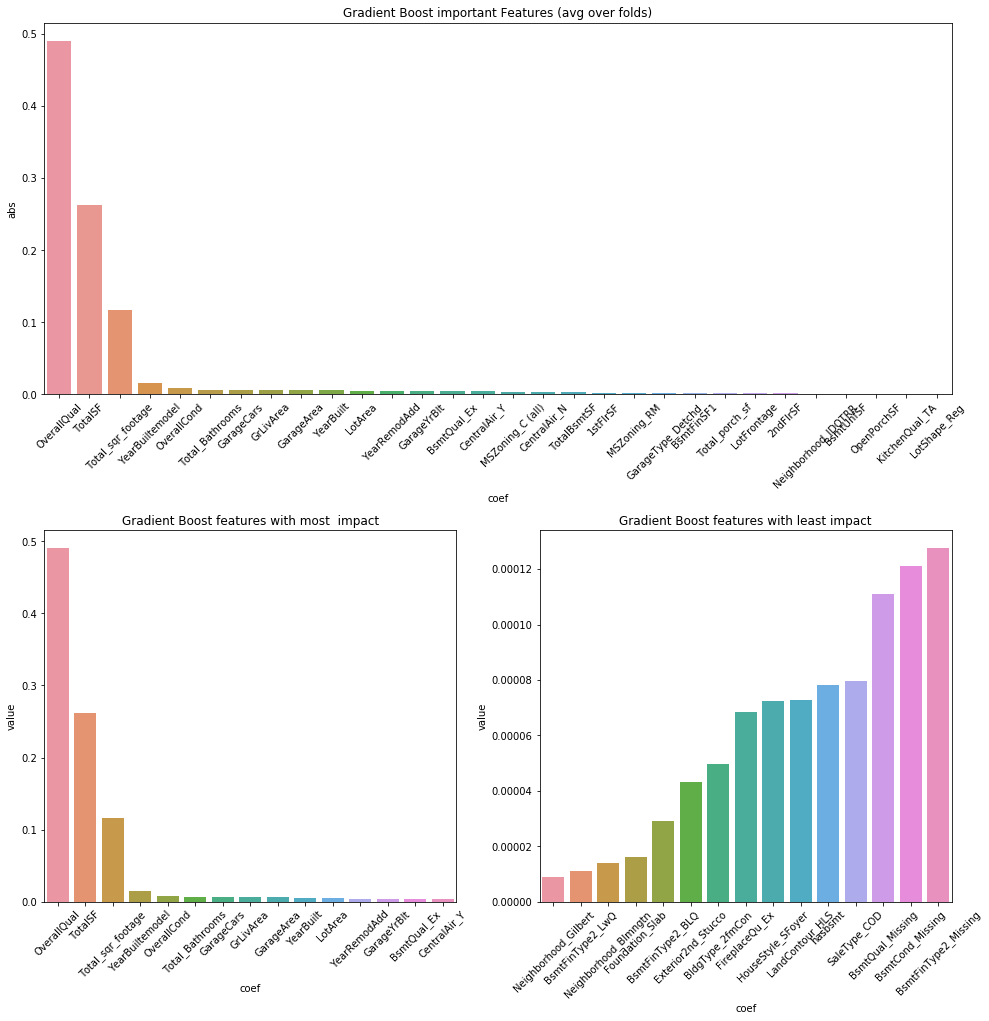

In [41]:
label_gboost=pd.DataFrame(list(zip(X.columns,gboost_final.feature_importances_)),columns=['coef','value']).sort_values(by='value')


#label_elasticnet=pd.DataFrame(list(zip(X.columns,elasticnet_final.coef_)),columns=['coef','value']).sort_values(by='value')
label_gboost = label_gboost[label_gboost.value!=0]
label_gboost['abs']=label_gboost.value.apply(lambda x:abs(x))
label_gboost['sign']=label_gboost.value.apply(lambda x: x/abs(x))

plt.figure(figsize = (14,14))
ax = plt.subplot2grid((2,2), (0,0), rowspan = 1, colspan = 2)

###########################################################################################################################
label_gboost_abs= label_gboost.sort_values(by='abs', ascending=False)
label_gboost_abs=label_gboost_abs.head(30)

sns.barplot(x="coef",
            y="abs",
             ax = ax, 
            data=label_randomforest_abs.sort_values(by="abs", ascending=False))
plt.title('Gradient Boost important Features (avg over folds)')
plt.tight_layout()
plt.xticks(rotation=45)
###########################################################################################################################

ax1 = plt.subplot2grid((2,2), (1,0), rowspan = 1, colspan = 1)

label_gboost_pos= label_gboost.sort_values(by='value', ascending=False)
label_gboost_pos=label_gboost_pos.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax1, 
            data=label_randomforest_pos.sort_values(by="value", ascending=False))
plt.title('Gradient Boost features with most  impact')
plt.tight_layout()
plt.xticks(rotation=45)

###########################################################################################################################
ax2 = plt.subplot2grid((2,2), (1,1), rowspan = 1, colspan = 1)

label_gboost_neg= label_gboost.sort_values(by='value', ascending=True)
label_gboost_neg=label_gboost_neg.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax2, 
            data=label_gboost_neg.sort_values(by="value", ascending=True))
plt.title('Gradient Boost features with least impact')
plt.tight_layout()
plt.xticks(rotation=45)


# LightGM

In [248]:
        #    num_leaves=4,
                                  #     learning_rate=0.01, 
                                   #    n_estimators=5000,
          #                                  max_bin=200, 
             #     #     #                               bagging_fraction=0.75,
                   #     #     #                         bagging_freq=5, 
                         #     #     #                   bagging_seed=7,
    #                                #     #             feature_fraction=0.2,
    #     #                                      #        feature_fraction_seed=7,
    #     #                                        verbose=-1,
          #                                   objective='regression', 
                                        
                                        
lgb_est = {'num_leaves':[4,5],
             'learning_rate' :  [0.01],
    'n_estimators': [4000,5000],
'max_bin':[200,250],
    'bagging_fraction':[0.6,0.7,0.8],
    'bagging_freq':[5],
    'feature_fraction':[0.1],
    'objective':['regression']
          }
lgb = LGBMRegressor()

In [249]:
lgb = RandomizedSearchCV(estimator=lgb,param_distributions =lgb_est, n_iter=15, cv = 5, verbose=2,n_jobs=-1, random_state=42)
lgb.fit(X_train, y_train)

print('score parameters for Light Gradient Boost Regression Model : {}'.format(lgb.grid_scores_))
print('Best parameters for Light Gradient Boost Regression Model : {}'.format(lgb.best_params_))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.3min finished


score parameters for Random Forest Regression Model : [mean: 0.92388, std: 0.00863, params: {'num_leaves': 4, 'bagging_fraction': 0.7, 'learning_rate': 0.01, 'n_estimators': 4000, 'max_bin': 200, 'objective': 'regression', 'bagging_freq': 5, 'feature_fraction': 0.1}, mean: 0.92391, std: 0.00889, params: {'num_leaves': 4, 'bagging_fraction': 0.8, 'learning_rate': 0.01, 'n_estimators': 4000, 'max_bin': 200, 'objective': 'regression', 'bagging_freq': 5, 'feature_fraction': 0.1}, mean: 0.92273, std: 0.00790, params: {'num_leaves': 4, 'bagging_fraction': 0.6, 'learning_rate': 0.01, 'n_estimators': 4000, 'max_bin': 200, 'objective': 'regression', 'bagging_freq': 5, 'feature_fraction': 0.1}, mean: 0.92420, std: 0.00872, params: {'num_leaves': 4, 'bagging_fraction': 0.8, 'learning_rate': 0.01, 'n_estimators': 5000, 'max_bin': 200, 'objective': 'regression', 'bagging_freq': 5, 'feature_fraction': 0.1}, mean: 0.92419, std: 0.00807, params: {'num_leaves': 5, 'bagging_fraction': 0.7, 'learning_rat

In [42]:
lgb_final = LGBMRegressor(objective='regression', 
                         num_leaves=5,
                                       learning_rate=0.01, 
                                       n_estimators=4000,
                                       max_bin=200, 
                                       bagging_fraction=0.7,
                                       bagging_freq=5, 
                                       feature_fraction=0.1,
                                       verbose=-1,
                                       )
lgb_final.fit(X_train,y_train)
#prediction = randomforest_final.predict(X_test)
print("Training accuracy:",lgb_final.score(X_train,y_train))
print("Testing accuracy:",lgb_final.score(X_test,y_test))


('Training accuracy:', 0.9727364610690844)
('Testing accuracy:', 0.9090969706982994)


In [411]:
score = cv_rmse_train(lgb_final)
print("Test data score of Light Gradient Boost: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('Test data score of Light Gradient Boost: 0.1076 (0.0135) 0.1211\n', datetime.datetime(2019, 4, 24, 9, 13, 24, 223000))


In [410]:
score = cv_rmse_test(lgb_final)
print("Test data score of Light Gradient Boost: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('Test data score of Light Gradient Boost: 0.1359 (0.0217) 0.1577\n', datetime.datetime(2019, 4, 24, 9, 12, 57, 144000))


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

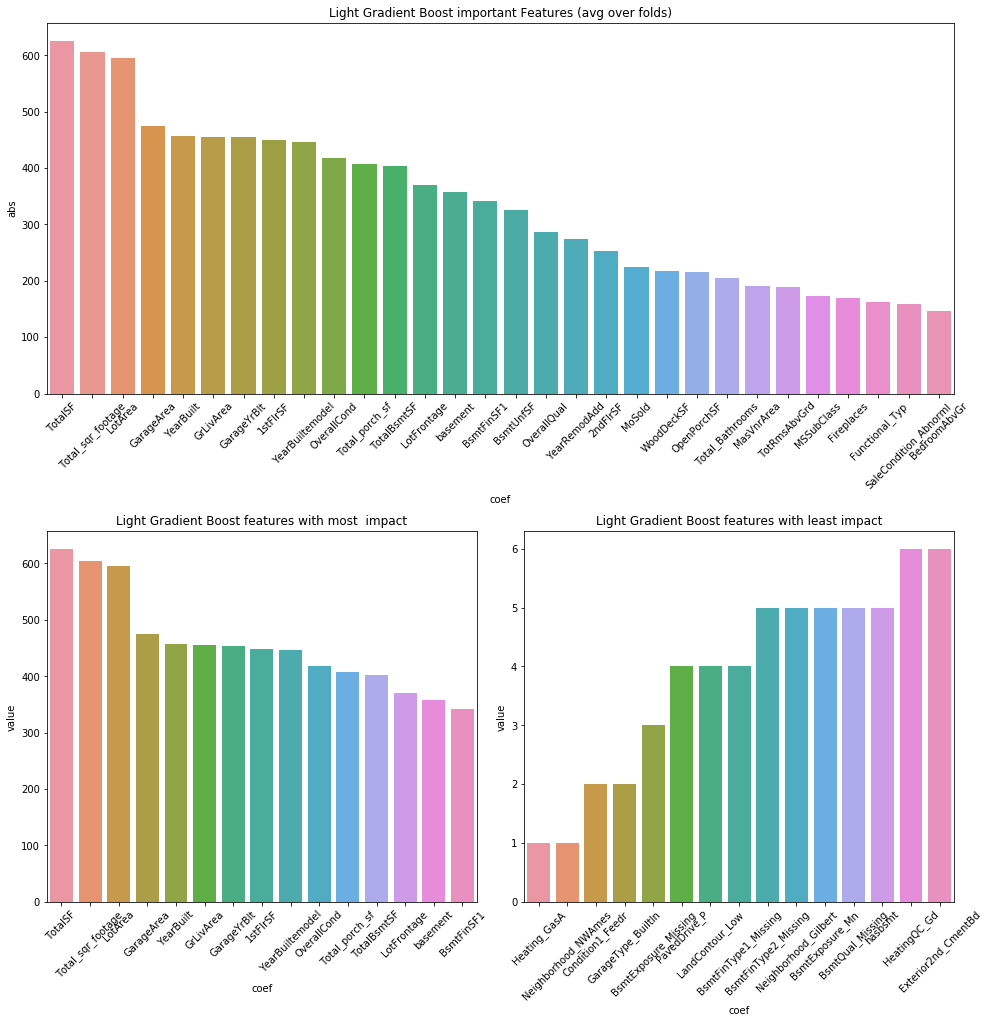

In [43]:
label_lgb=pd.DataFrame(list(zip(X.columns,lgb_final.feature_importances_)),columns=['coef','value']).sort_values(by='value')


#label_elasticnet=pd.DataFrame(list(zip(X.columns,elasticnet_final.coef_)),columns=['coef','value']).sort_values(by='value')
label_lgb = label_lgb[label_lgb.value!=0]
label_lgb['abs']=label_lgb.value.apply(lambda x:abs(x))
label_lgb['sign']=label_lgb.value.apply(lambda x: x/abs(x))

plt.figure(figsize = (14,14))
ax = plt.subplot2grid((2,2), (0,0), rowspan = 1, colspan = 2)

###########################################################################################################################
label_lgb_abs= label_lgb.sort_values(by='abs', ascending=False)
label_lgb_abs=label_lgb_abs.head(30)

sns.barplot(x="coef",
            y="abs",
             ax = ax, 
            data=label_lgb_abs.sort_values(by="abs", ascending=False))
plt.title('Light Gradient Boost important Features (avg over folds)')
plt.tight_layout()
plt.xticks(rotation=45)
###########################################################################################################################

ax1 = plt.subplot2grid((2,2), (1,0), rowspan = 1, colspan = 1)

label_lgb_pos= label_lgb.sort_values(by='value', ascending=False)
label_lgb_pos=label_lgb_pos.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax1, 
            data=label_lgb_pos.sort_values(by="value", ascending=False))
plt.title('Light Gradient Boost features with most  impact')
plt.tight_layout()
plt.xticks(rotation=45)

###########################################################################################################################
ax2 = plt.subplot2grid((2,2), (1,1), rowspan = 1, colspan = 1)

label_lgb_neg= label_lgb.sort_values(by='value', ascending=True)
label_lgb_neg=label_lgb_neg.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax2, 
            data=label_lgb_neg.sort_values(by="value", ascending=True))
plt.title('Light Gradient Boost features with least impact')
plt.tight_layout()
plt.xticks(rotation=45)


# XgBoost

In [44]:
xgb_est = {
             'learning_rate' :  [0.01,0.015,0.02,0.025],
    'n_estimators': [2500,3000,3500],
             'max_depth': [ 3, 4],
    'min_child_weight' : [ 0,1],
 'gamma' : [ 0.0],
     'colsample_bytree' : [ 0.6, 0.7 ,0.8],
    'subsample' : [0.6,0.7,0.8],
     'objective':['reg:linear']
  #  'nthread':[-1],
#    'scale_pos_weight' = # keep default as 1
  #  'seed' = 
           
             }


#learning_rate=0.01,
#n_estimators=3460,
    #                                 max_depth=3,
  #  min_child_weight=0,
  #                                   gamma=0,
      #  subsample=0.7, # Typical values range between 0.5-0.9.
                                #     colsample_bytree=0.7,
                                #     objective='reg:linear', https://xgboost.readthedocs.io/en/latest/parameter.html
            #    nthread=-1,
                                     #scale_pos_weight=1, 
              #      seed=27,
               #                      reg_alpha=0.00006)

In [414]:
xgboost = XGBRegressor()
xgboost = RandomizedSearchCV(estimator=xgboost,param_distributions =xgb_est, n_iter=15, cv = 5, verbose=2,n_jobs=-1, random_state=42)
xgboost.fit(X_train,y_train)

print('score parameters for xgboost Regression Model : {}'.format(xgboost.grid_scores_))
print('Best parameters for xgboost Regression Model : {}'.format(xgboost.best_params_))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.1min finished


score parameters for Random Forest Regression Model : [mean: 0.92969, std: 0.00906, params: {'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 1, 'n_estimators': 2500, 'subsample': 0.7, 'objective': 'reg:linear', 'max_depth': 4, 'gamma': 0.0}, mean: 0.93148, std: 0.01004, params: {'colsample_bytree': 0.6, 'learning_rate': 0.02, 'min_child_weight': 0, 'n_estimators': 3000, 'subsample': 0.6, 'objective': 'reg:linear', 'max_depth': 3, 'gamma': 0.0}, mean: 0.93119, std: 0.00928, params: {'colsample_bytree': 0.7, 'learning_rate': 0.015, 'min_child_weight': 0, 'n_estimators': 2500, 'subsample': 0.6, 'objective': 'reg:linear', 'max_depth': 3, 'gamma': 0.0}, mean: 0.93175, std: 0.00781, params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 3000, 'subsample': 0.6, 'objective': 'reg:linear', 'max_depth': 4, 'gamma': 0.0}, mean: 0.93084, std: 0.00854, params: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'min_child_weight': 1, 'n_est

In [45]:
xgboost_final = XGBRegressor(learning_rate=0.015,n_estimators=2500,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.6,
                                     colsample_bytree=0.6,
                                     objective='reg:linear',
                                     nthread=-1,
                                     scale_pos_weight=1) 
xgboost_final.fit(X_train,y_train)

#prediction = randomforest_final.predict(X_test)
print("Training accuracy:",xgboost_final.score(X_train,y_train))
print("Testing accuracy:",xgboost_final.score(X_test,y_test))
#                    feature_importances_

('Training accuracy:', 0.9906898743277663)
('Testing accuracy:', 0.9140435576714219)


In [421]:
score = cv_rmse_train(xgboost_final)
print("Train data score ofxgboost: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('Train data score of ridge Boost forest: 0.1018 (0.0133) 0.1151\n', datetime.datetime(2019, 4, 24, 18, 38, 39, 394000))


In [425]:
score = cv_rmse_test(xgboost_final)
print("Test data score of xgboost: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('Test data score of ridge Boost forest: 0.1262 (0.0246) 0.1507\n', datetime.datetime(2019, 4, 24, 18, 41, 44, 76000))


#### Feature importance


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

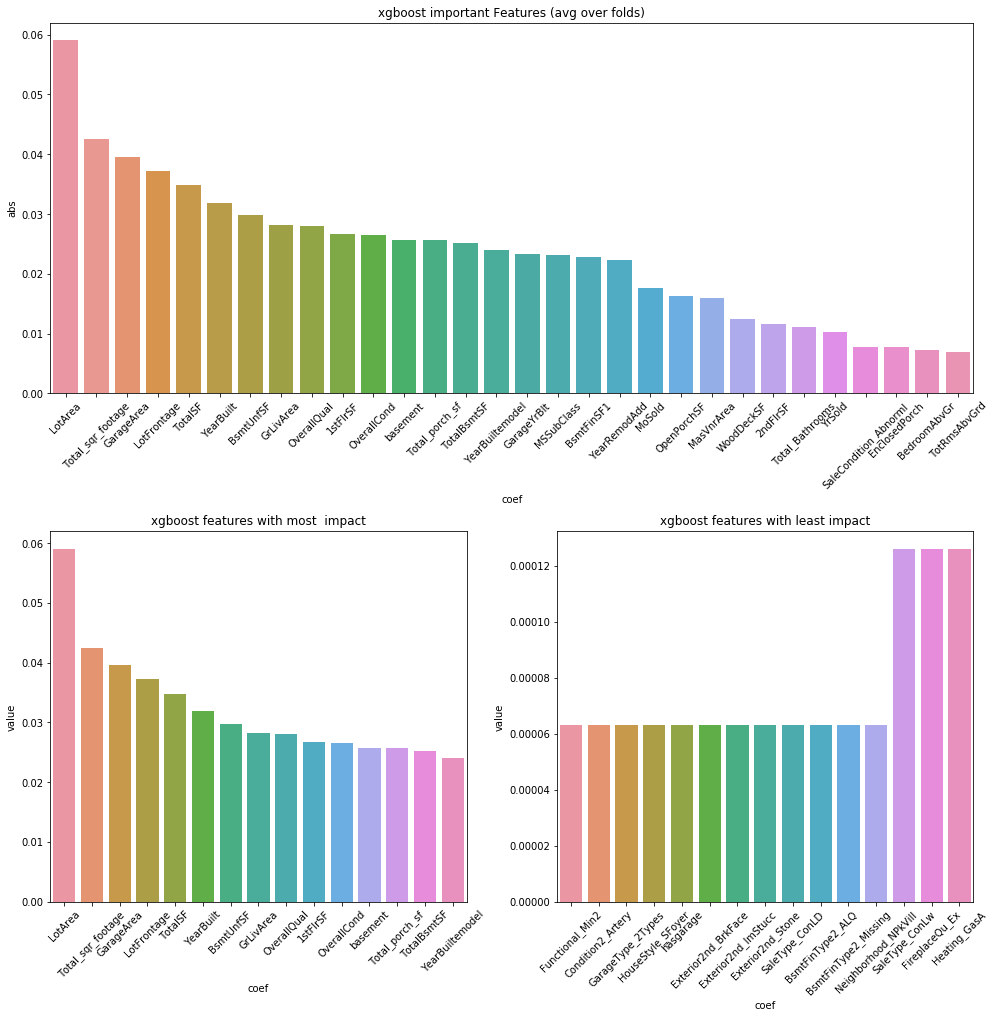

In [46]:
label_xgboost=pd.DataFrame(list(zip(X.columns,xgboost_final.feature_importances_)),columns=['coef','value']).sort_values(by='value')


#label_elasticnet=pd.DataFrame(list(zip(X.columns,elasticnet_final.coef_)),columns=['coef','value']).sort_values(by='value')
label_xgboost = label_xgboost[label_xgboost.value!=0]
label_xgboost['abs']=label_xgboost.value.apply(lambda x:abs(x))
label_xgboost['sign']=label_xgboost.value.apply(lambda x: x/abs(x))

plt.figure(figsize = (14,14))
ax = plt.subplot2grid((2,2), (0,0), rowspan = 1, colspan = 2)

###########################################################################################################################
label_xgboost_abs= label_xgboost.sort_values(by='abs', ascending=False)
label_xgboost_abs=label_xgboost_abs.head(30)

sns.barplot(x="coef",
            y="abs",
             ax = ax, 
            data=label_xgboost_abs.sort_values(by="abs", ascending=False))
plt.title('xgboost important Features (avg over folds)')
plt.tight_layout()
plt.xticks(rotation=45)
###########################################################################################################################

ax1 = plt.subplot2grid((2,2), (1,0), rowspan = 1, colspan = 1)

label_xgboost_pos= label_xgboost.sort_values(by='value', ascending=False)
label_xgboost_pos=label_xgboost_pos.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax1, 
            data=label_xgboost_pos.sort_values(by="value", ascending=False))
plt.title('xgboost features with most  impact')
plt.tight_layout()
plt.xticks(rotation=45)

###########################################################################################################################
ax2 = plt.subplot2grid((2,2), (1,1), rowspan = 1, colspan = 1)

label_xgboost_neg= label_xgboost.sort_values(by='value', ascending=True)
label_xgboost_neg=label_xgboost_neg.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax2, 
            data=label_xgboost_neg.sort_values(by="value", ascending=True))
plt.title('xgboost features with least impact')
plt.tight_layout()
plt.xticks(rotation=45)


# ADA Boost

In [445]:
param_grid = {   'n_estimators':[5000,4000, 3000,2000],
               'learning_rate':[ 0.01,0.1,0.9,1,1.1,1.2],
                        'loss' : ['linear', 'square', 'exponential']}
ada = AdaBoostRegressor()

In [446]:
ada = RandomizedSearchCV(estimator = ada, param_distributions =param_grid, n_iter=20, cv = 3,scoring='neg_mean_squared_error', verbose=2,n_jobs=-1, random_state=42)
ada.fit(X_train,y_train)

print('score parameters for Random Forest Regression Model : {}'.format(ada.grid_scores_))
print('Best parameters for Random Forest Regression Model : {}'.format(ada.best_params_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.8min finished


score parameters for Random Forest Regression Model : [mean: -0.02181, std: 0.00240, params: {'n_estimators': 5000, 'loss': 'square', 'learning_rate': 0.01}, mean: -0.02051, std: 0.00171, params: {'n_estimators': 3000, 'loss': 'linear', 'learning_rate': 1.2}, mean: -0.02139, std: 0.00192, params: {'n_estimators': 3000, 'loss': 'square', 'learning_rate': 0.1}, mean: -0.02164, std: 0.00224, params: {'n_estimators': 5000, 'loss': 'linear', 'learning_rate': 0.01}, mean: -0.02091, std: 0.00185, params: {'n_estimators': 5000, 'loss': 'square', 'learning_rate': 0.9}, mean: -0.02061, std: 0.00175, params: {'n_estimators': 3000, 'loss': 'linear', 'learning_rate': 1.1}, mean: -0.02244, std: 0.00237, params: {'n_estimators': 3000, 'loss': 'exponential', 'learning_rate': 0.01}, mean: -0.02062, std: 0.00191, params: {'n_estimators': 3000, 'loss': 'exponential', 'learning_rate': 0.9}, mean: -0.02101, std: 0.00185, params: {'n_estimators': 5000, 'loss': 'linear', 'learning_rate': 0.1}, mean: -0.02079

In [49]:
ada_final = AdaBoostRegressor(n_estimators =  4000, learning_rate= 1.1,loss= 'linear' )
ada_final.fit(X_train,y_train)
#prediction = randomforest_final.predict(X_test)
print("Training accuracy:",ada_final.score(X_train,y_train))
print("Testing accuracy:",ada_final.score(X_test,y_test))


('Training accuracy:', 0.9081721663883433)
('Testing accuracy:', 0.8469326708723257)


In [449]:
score = cv_rmse_train(ada_final)
print("Train data score of ridge Boost forest: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('Train data score of ridge Boost forest: 0.1401 (0.0102) 0.1503\n', datetime.datetime(2019, 4, 24, 19, 19, 24, 195000))


In [448]:
score = cv_rmse_test(ada_final)
print("Test data score of ridge Boost forest: {:.4f} ({:.4f}) {:.4f}""\n".format(score.mean(), score.std(),score.mean()+score.std()), datetime.now(), )

('Test data score of ridge Boost forest: 0.1630 (0.0268) 0.1898\n', datetime.datetime(2019, 4, 24, 19, 7, 58, 405000))


#### Important Featurems

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

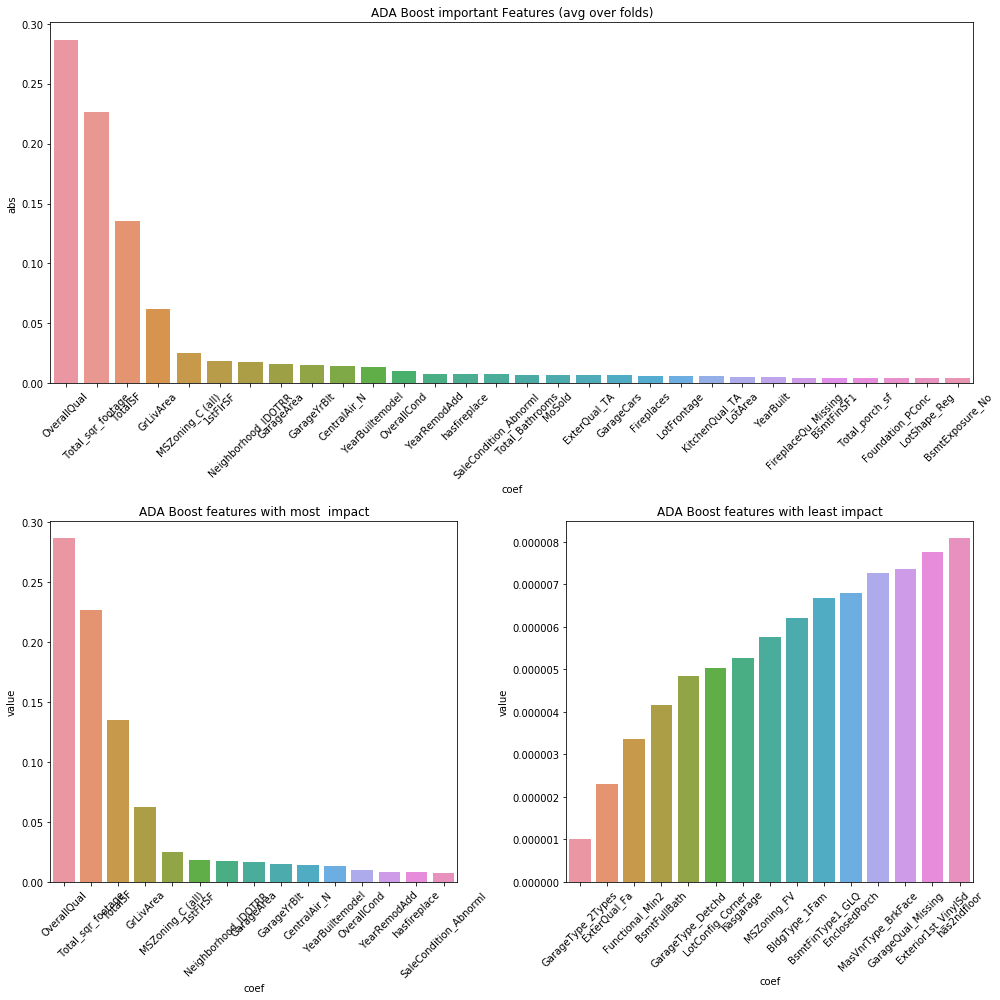

In [50]:
label_ada=pd.DataFrame(list(zip(X.columns,ada_final.feature_importances_)),columns=['coef','value']).sort_values(by='value')


#label_elasticnet=pd.DataFrame(list(zip(X.columns,elasticnet_final.coef_)),columns=['coef','value']).sort_values(by='value')
label_ada = label_ada[label_ada.value!=0]
label_ada['abs']=label_ada.value.apply(lambda x:abs(x))
label_ada['sign']=label_ada.value.apply(lambda x: x/abs(x))

plt.figure(figsize = (14,14))
ax = plt.subplot2grid((2,2), (0,0), rowspan = 1, colspan = 2)

###########################################################################################################################
label_ada_abs= label_ada.sort_values(by='abs', ascending=False)
label_ada_abs=label_ada_abs.head(30)

sns.barplot(x="coef",
            y="abs",
             ax = ax, 
            data=label_ada_abs.sort_values(by="abs", ascending=False))
plt.title('ADA Boost important Features (avg over folds)')
plt.tight_layout()
plt.xticks(rotation=45)
###########################################################################################################################

ax1 = plt.subplot2grid((2,2), (1,0), rowspan = 1, colspan = 1)

label_ada_pos= label_ada.sort_values(by='value', ascending=False)
label_ada_pos=label_ada_pos.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax1, 
            data=label_ada_pos.sort_values(by="value", ascending=False))
plt.title('ADA Boost features with most  impact')
plt.tight_layout()
plt.xticks(rotation=45)

###########################################################################################################################
ax2 = plt.subplot2grid((2,2), (1,1), rowspan = 1, colspan = 1)

label_ada_neg= label_ada.sort_values(by='value', ascending=True)
label_ada_neg=label_ada_neg.head(15)
sns.barplot(x="coef",
            y="value",
            ax = ax2, 
            data=label_ada_neg.sort_values(by="value", ascending=True))
plt.title('ADA Boost features with least impact')
plt.tight_layout()
plt.xticks(rotation=45)


# Most iportant Feature

Text(108.625,0.5,'No of times feature was in top 15 feature')

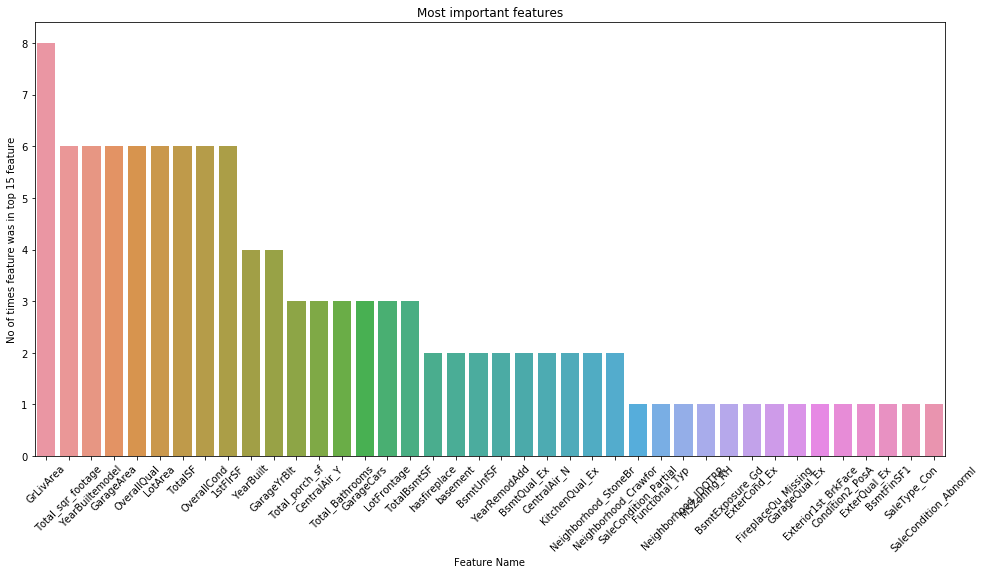

In [51]:
Important_Label = label_lasso_pos.append([label_ridge_pos,label_elasticnet_pos,label_randomforest_pos,label_gboost_pos,
                                          label_lgb_pos,label_xgboost_pos,label_ada_pos])
Important_Label=Important_Label.coef.value_counts()
Important_Label = Important_Label.rename_axis('unique_values').reset_index(name='counts')
Important_Label=Important_Label.head(40)
plt.figure(figsize = (14,7))

sns.barplot(x="unique_values",
            y="counts",
            data=Important_Label.sort_values(by="counts", ascending=False))
plt.title('Most important features')
plt.tight_layout()
plt.xticks(rotation=45)
plt.xlabel("Feature Name")
plt.ylabel("No of times feature was in top 15 feature")


From Above Chart we can clearly say that:
* most important factores that effect positive impact on house price are Area,Quality,how old is house
* living area, garage,porch,airconditioning and bathroom also have big impact
* fireplace , basement , having nice neighbourhood and sale type or condition is also a good predcitor
* Feature engineered features like Total_Sql_footage, TotalSF are very good parameter
* parameter like has fireplace is ore important then area or qulaty of fireplace

Text(99,0.5,'No of times feature was in top 15 feature')

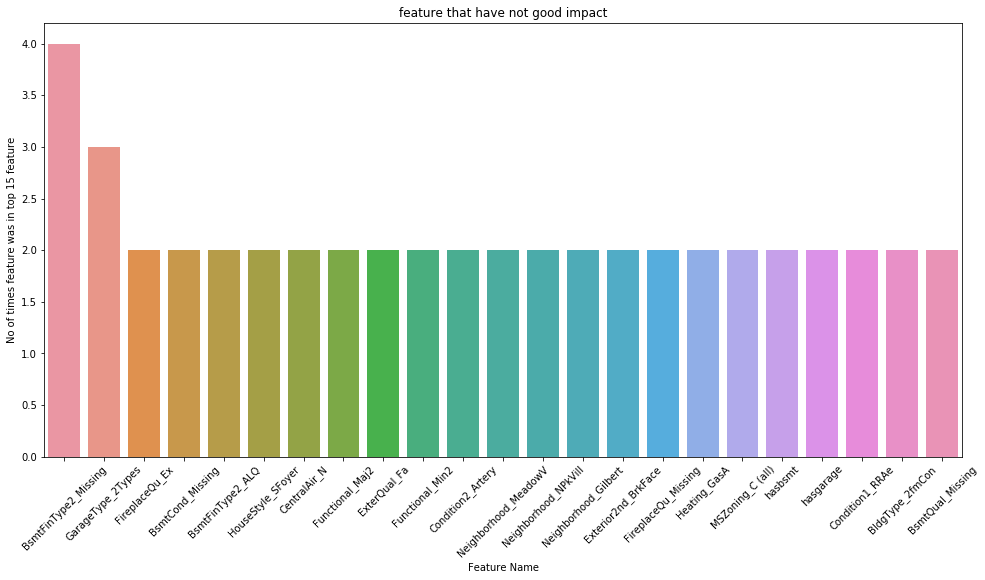

In [76]:
bad_Label = label_lasso_neg.append([label_ridge_neg,label_elasticnet_neg,label_randomforest_neg,label_gboost_neg,
                                          label_lgb_neg,label_xgboost_neg,label_ada_neg])
bad_Label=bad_Label.coef.value_counts()
bad_Label = bad_Label.rename_axis('unique_values').reset_index(name='counts')
bad_Label=bad_Label.head(23)
plt.figure(figsize = (14,7))

sns.barplot(x="unique_values",
            y="counts",
            data=bad_Label.sort_values(by="counts", ascending=False))
plt.title('feature that have not good impact')
plt.tight_layout()
plt.xticks(rotation=45)
plt.xlabel("Feature Name")
plt.ylabel("No of times feature was in top 15 feature")


From above graph it can be conculded that
* house without basement and house with two different tyoe of garage has neglible impact on house price
* even though having fireplace can be good, people do ignore what is quality of fireplace
* not having garage, basement or any other section does not have any positive impact

# Compare Models

### Calculate test and train score

In [511]:
#print("Train Score calculation({:.4f})\n".format(datetime.now(), )
lasso_score_train = cv_rmse_train(losso_final)
print("lasso: {:.4f} ({:.4f})\n".format(lasso_score_train.mean(), lasso_score_train.std()), datetime.now(), )
lassocv_score_train = cv_rmse_train(lassocv)
print("lassocv: {:.4f} ({:.4f})\n".format(lassocv_score_train.mean(), lassocv_score_train.std()), datetime.now(), )
ridge_score_train = cv_rmse_train(ridge_final)
print("ridge: {:.4f} ({:.4f})\n".format(ridge_score_train.mean(), ridge_score_train.std()), datetime.now(), )
ridgecv_score_train = cv_rmse_train(ridgecv)
print("ridgecv: {:.4f} ({:.4f})\n".format(ridgecv_score_train.mean(), ridgecv_score_train.std()), datetime.now(), )
elasticnet_score_train = cv_rmse_train(elasticnet_final)
print("elasticne: {:.4f} ({:.4f})\n".format(elasticnet_score_train.mean(), elasticnet_score_train.std()), datetime.now(), )
elasticnetcv_score_train = cv_rmse_train(elasticnetcv)
print("elasticnetcv: {:.4f} ({:.4f})\n".format(elasticnetcv_score_train.mean(), elasticnetcv_score_train.std()), datetime.now(), )
randomforest_score_train = cv_rmse_train(randomforest_final)
print("randomforest: {:.4f} ({:.4f})\n".format(randomforest_score_train.mean(), randomforest_score_train.std()), datetime.now(), )
gboost_score_train = cv_rmse_train(gboost_final)
print("gboost: {:.4f} ({:.4f})\n".format(gboost_score_train.mean(), gboost_score_train.std()), datetime.now(), )
lgb_score_train = cv_rmse_train(lgb_final)
print("lgb: {:.4f} ({:.4f})\n".format(lgb_score_train.mean(), lgb_score_train.std()), datetime.now(), )
xgboost_score_train = cv_rmse_train(xgboost_final)
print("xgboost: {:.4f} ({:.4f})\n".format(xgboost_score_train.mean(), xgboost_score_train.std()), datetime.now(), )
ada_score_train = cv_rmse_train(ada_final)
print("ada: {:.4f} ({:.4f})\n".format(ada_score_train.mean(), ada_score_train.std()), datetime.now(), )

('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 4, 32, 106000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 4, 53, 532000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 4, 53, 700000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 5, 15, 606000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 5, 15, 870000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 6, 8, 190000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 13, 44, 983000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 14, 31, 560000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 14, 48, 338000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 15, 32, 799000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 20, 37, 308000))


In [512]:
lasso_score_test = cv_rmse_test(losso_final)
print("lasso_score_test: {:.4f} ({:.4f})\n".format(lasso_score_test.mean(), lasso_score_test.std()), datetime.now(), )
lassocv_score_test = cv_rmse_test(lassocv)
print("lassocv_score_test: {:.4f} ({:.4f})\n".format(lassocv_score_test.mean(), lassocv_score_test.std()), datetime.now(), )
ridge_score_test = cv_rmse_test(ridge_final)
print("ridge_score_test: {:.4f} ({:.4f})\n".format(ridge_score_test.mean(), ridge_score_test.std()), datetime.now(), )
ridgecv_score_test = cv_rmse_test(ridgecv)
print("ridgecv_score_test: {:.4f} ({:.4f})\n".format(ridgecv_score_test.mean(), ridgecv_score_test.std()), datetime.now(), )
elasticnet_score_test = cv_rmse_test(elasticnet_final)
print("elasticnet_score_test: {:.4f} ({:.4f})\n".format(elasticnet_score_test.mean(), elasticnet_score_test.std()), datetime.now(), )
elasticnetcv_score_test = cv_rmse_test(elasticnetcv)
print("elasticnetcv_score_test: {:.4f} ({:.4f})\n".format(elasticnetcv_score_test.mean(), elasticnetcv_score_test.std()), datetime.now(), )
randomforest_score_test = cv_rmse_test(randomforest_final)
print("randomforest_score_test: {:.4f} ({:.4f})\n".format(randomforest_score_test.mean(), randomforest_score_test.std()), datetime.now(), )
gboost_score_test = cv_rmse_test(gboost_final)
print("gboost_score_test: {:.4f} ({:.4f})\n".format(gboost_score_test.mean(), gboost_score_test.std()), datetime.now(), )
lgb_score_test = cv_rmse_test(lgb_final)
print("lgb_score_test: {:.4f} ({:.4f})\n".format(lgb_score_test.mean(), lgb_score_test.std()), datetime.now(), )
xgboost_score_test = cv_rmse_test(xgboost_final)
print("xgboost_score_test: {:.4f} ({:.4f})\n".format(xgboost_score_test.mean(), xgboost_score_test.std()), datetime.now(), )
ada_score_test = cv_rmse_test(ada_final)
print("ada_score_test: {:.4f} ({:.4f})\n".format(ada_score_test.mean(), ada_score_test.std()), datetime.now(), )

('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 20, 37, 404000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 21, 15, 524000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 21, 15, 568000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 21, 21, 513000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 21, 21, 621000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 22, 56, 794000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 39, 24, 40000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 39, 54, 627000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 40, 8, 36000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 40, 24, 605000))
('gbr: 0.1401 (0.0102)\n', datetime.datetime(2019, 4, 25, 20, 42, 20, 194000))


In [503]:
compare_model = pd.DataFrame(np.zeros((2, 12)),columns=['TestTrainScore','Lasso','LassoCV','Ridge','RidgeCV','ElasticNet',
                                                 'ElasticNetCV','Random Forest','Gradient Boost','Light GB','XGBoost','ADA Boost'])


In [506]:
#compare.iloc[[0],[0]] = ada_score.mean()
compare_model.TestTrainScore.iloc[[0]] = 'Test Score'
compare_model.TestTrainScore.iloc[[1]] = 'Train Score'


In [515]:
compare_model.iloc[[0],[1]]=lasso_score_test.mean()
compare_model.iloc[[0],[2]]=lassocv_score_test.mean()
compare_model.iloc[[0],[3]]=ridge_score_test.mean()
compare_model.iloc[[0],[4]]=ridgecv_score_test.mean()
compare_model.iloc[[0],[5]]=elasticnet_score_test.mean()
compare_model.iloc[[0],[6]]=elasticnetcv_score_test.mean()
compare_model.iloc[[0],[7]]=randomforest_score_test.mean()
compare_model.iloc[[0],[8]]=gboost_score_test.mean()
compare_model.iloc[[0],[9]]=lgb_score_test.mean()
compare_model.iloc[[0],[10]]=xgboost_score_test.mean()
compare_model.iloc[[0],[11]]=ada_score_test.mean()

In [517]:
compare_model.iloc[[1],[1]]=lasso_score_train.mean()
compare_model.iloc[[1],[2]]=lassocv_score_train.mean()
compare_model.iloc[[1],[3]]=ridge_score_train.mean()
compare_model.iloc[[1],[4]]=ridgecv_score_train.mean()
compare_model.iloc[[1],[5]]=elasticnet_score_train.mean()
compare_model.iloc[[1],[6]]=elasticnetcv_score_train.mean()
compare_model.iloc[[1],[7]]=randomforest_score_train.mean()
compare_model.iloc[[1],[8]]=gboost_score_train.mean()
compare_model.iloc[[1],[9]]=lgb_score_train.mean()
compare_model.iloc[[1],[10]]=xgboost_score_train.mean()
compare_model.iloc[[1],[11]]=ada_score_train.mean()

In [518]:
compare_model

,TestTrainScore,Lasso,LassoCV,Ridge,RidgeCV,ElasticNet,ElasticNetCV,Random Forest,Gradient Boost,Light GB,XGBoost,ADA Boost
0,Test Score,0.128165,0.132889,0.142053,0.139882,0.125176,0.143047,0.158162,0.132372,0.135929,0.126155,0.162538
1,Train Score,0.136730,0.101309,0.104228,0.099705,0.113817,0.098656,0.136490,0.104854,0.107608,0.101965,0.140163


* best algorithms which canbe used are Lasso,XgBoost,Elastic Net
* Randon forest and Ada Boost are not very good predictors
* execution time of three selected algorithm is also less
* ADA boost and RandomForest are not very good predictors or may need more hyper parameter tunning
* Gradient Boost and Light Gradient boost are not bed predictors either

# predict Test Data

In [111]:
def blend_models_predict(X):
    return ((0.2 * losso_final.predict(X)) + \
            #    (0.05 * lassocv.predict(X)) + \
            (0.1 * ridge_final.predict(X)) + \
            (0.1 * ridgecv.predict(X)) + \
            (0.3 * elasticnet_final.predict(X)) + \
       #         (0.05 * elasticnetcv.predict(X)) + \
           #     (0.05 * randomforest_final.predict(X)) + \
            (0.1 * gboost_final.predict(X)) + \
          #      (0.05 * lgb_final.predict(X)) + \
            (0.2 * xgboost_final.predict(X))) #+ \
     #           (0.05 * ada_final.predict(X)))

In [120]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.08334388450463798


#### Predict value then exponential it as we used log value of dependat value in modelling

In [121]:
print('Predict submission')
submission = pd.read_csv("../sample_submission.csv")
submission.iloc[:,1] = (np.expm1(blend_models_predict(X_sub)))

Predict submission


In [122]:
q1 = submission['SalePrice'].quantile(0.0042)
q2 = submission['SalePrice'].quantile(0.99)
# Quantiles helping us get some extreme values for extremely low or high values 
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission.csv", index=False)